# Advanced Unittest

This lesson continues to discuss the Python standard library module `unittest`. We will look at decorators to test methods, subtests, and integrating with doctest.

The structure of our hypothetical `fractal` library is typical or real projects. Larger projects will have more modules and perhaps subdirectories, but follow a similar pattern.

```
Fractal
├── fractal
│   ├── julia.py
│   ├── koch.py
│   ├── mandelbrot.py
│   ├── sierpiński.py
│   └── visualize.py
```

```
└── test
    ├── __init__.py
    ├── test_canvas.py
    └── test_points.py
```

As with the last lesson we want to make available the path to our project directory.

In [1]:
import os, sys
sys.path.append('Fractal')
os.environ['PYTHONPATH'] = 'Fractal'
from fractal.julia import *
from fractal.visualize import *

Our library allows us to generate and visualize fractals. For example:

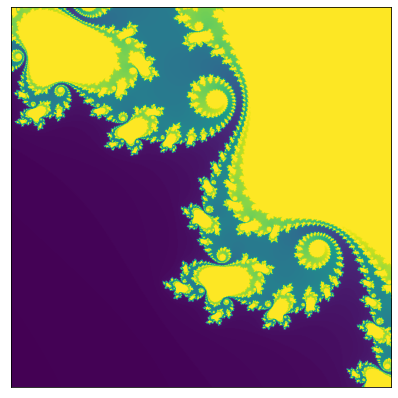

In [2]:
canvas = make_canvas(julia, 0.1015, -0.633, 0.01, 800)
visualize(canvas)

## Fixing bugs

In the last lesson, we determined, **via a unit test**, that the documentation and implementation of `make_canvas()` were inconsistent.  The initial docstring had read:

```
Create a 'canvas' based on an arbitrary function fn:ℂ🠖ℕ

fn:     function visualized
x:      lower-left (smallest) real coordinate
y:      lower-left (smallest) imaginary coordinate
size:   numeric range of value to plot in each coord
pixels: size of generated graph in pixels (square)
```



The actual code uses `x` and `y` instead as the **center** of the rendered region.  Let us assume that we consulted the customer and the specs, and determined that the code was correct, and the documentation needed to change.

In [3]:
help(make_canvas)

Help on function make_canvas in module fractal.visualize:

make_canvas(fn, x, y, size, pixels, kws={})
    Create a 'canvas' based on an arbitrary function fn:ℂ🠖ℕ
    
    fn:     function visualized
    x:      real coordinate of center
    y:      imaginary coordinate of center
    size:   numeric range of value to plot in each coord
    pixels: size of generated graph in pixels (square)
    
    Canvas is NumPy array of dtype uint8 (0 <= n <= 255)



A problem remains that the test we wrote based on the documentation will continue to fail.

## Test decorators

You can modify the behavior of test cases by using decorators.  For example, rather than discard the test of the assumption the canvas lower-left is $x+yi$, we can retain the logic but indicate that we expect it to fail.

```python
class TestCanvasDocs(unittest.TestCase):
    def setUp(self):
        self.fn = lambda c: max(int(c.real), int(c.imag)) % 255
        self.canvas = make_canvas(self.fn, 0, 0, 800, 800)
        self.center = 400
```

This test method is renamed from prior lesson, and decorated, but is otherwise identical

```python
    @unittest.expectedFailure
    def test_position_values_lowerleft(self):
        "Verify values in correct place on canvas"
        for x in range(0, 100, 10):
            for y in range(50, 150, 10):
                self.assertEqual(self.canvas[x, y], 
                                 self.fn(x+y*1j),
                                 msg=f"Error for fn({x}+{y}j)")
```

In [4]:
!python -m unittest test.test_canvas.TestCanvasDocs.test_position_values_lowerleft

x
----------------------------------------------------------------------
Ran 1 test in 0.937s

OK (expected failures=1)


A number of other decorators are also available.

```python
    @unittest.skipUnless(sys.version_info >= (3, 6), 
                         "F-strings require recent Pythons")
    def test_div_zero(self):
        with self.assertRaises(ZeroDivisionError):
            denom = "0"
            x = 1/int(f"{denom}")
```

In [5]:
!python -m unittest test.test_canvas.TestCanvasDocs.test_div_zero

.
----------------------------------------------------------------------
Ran 1 test in 0.930s

OK


```python
    @unittest.skipIf(sys.platform.startswith("linux"), 
                         "Do not test on Linux")
    def test_broken_math(self):
        self.assertEqual(2+2, 5)
```

In [6]:
!python -m unittest test.test_canvas.TestCanvasDocs.test_broken_math

s
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK (skipped=1)


We need to create a test of the actual intended behavior as well, now that the docstring has been fixed. 

```python
    def test_position_center(self):
        "Verify values in correct place on canvas"
        for x in range(0, 100, 10):
            for y in range(50, 150, 10):
                msg=f"Error for simple_fn({x}+{y}j)"
                self.assertEqual(self.canvas[x+self.center, 
                                             y+self.center], 
                                 self.fn(x+y*1j), msg=msg)
```

Let us run all the tests in the entire file `test_canvas.py`.

In [7]:
!python -m unittest test.test_canvas

....s..x
----------------------------------------------------------------------
Ran 8 tests in 6.328s

OK (skipped=1, expected failures=1)


## Subtests

In several tests that we have designed, the test looped through related values and checked whether some property held across a range of options.  This is useful, but it provides a coarse judgement of "always passes" versus "sometimes fails."  

Many operations, moreover, have non-determinism in them, and we would like a better sense of when a test passes or fails.

In [18]:
os.environ['SKIP_RANDOM'] = ""
!python -m unittest test.test_points.TestRandom


FAIL: test_random (test.test_points.TestRandom) (r=0.9544233498463969)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/dmertz/git/INE/unittest/03-Advanced-Unittest/Fractal/test/test_points.py", line 13, in test_random
    self.assertTrue(r < 0.9, msg="Value exceeds bounds")
AssertionError: False is not true : Value exceeds bounds

FAIL: test_random (test.test_points.TestRandom) (r=0.915517167374376)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/dmertz/git/INE/unittest/03-Advanced-Unittest/Fractal/test/test_points.py", line 13, in test_random
    self.assertTrue(r < 0.9, msg="Value exceeds bounds")
AssertionError: False is not true : Value exceeds bounds

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=2)


If we structure related tests using a `subTest()` context manager we can get more informative results.

```python
@unittest.skipIf(os.environ.get('SKIP_RANDOM'), 
                     "Skipping on ENV setting")
class TestRandom(unittest.TestCase):
    def test_random(self):
        for i in range(10):
            r = random()
            with self.subTest(r=r):
                self.assertTrue(r < 0.9, 
                                msg="Value exceeds bounds")
```

The example in `TestRandom` is artificial.  But, for example, `TestCanvas` can and should be modified to produce similar detailed failure reports (i.e. if some canvas shapes behaved wrongly).

```python
    def test_canvas_size(self):
        for n in range(8):
            with self.subTest(n=n):
                pixels = 2**n
                size = randrange(0, pixels)
                canvas = make_canvas(self.simple_fn, 0, 0, 
                                     size, pixels)
                msg = f"Unexpected canvas size {canvas.shape}"
                self.assertEqual(canvas.shape, (pixels, pixels), 
                                 msg=msg)
```

## Integrating doctests

Although many kinds of tests are better expressed with `unittest` than with `doctest`, the two can play well together.  Including doctests within the unittest framework only requires a few lines of code.  The special function `load_tests()` performs this integration.  

For example, in `test_points.py`:

```python
import unittest, doctest
from fractal import mandelbrot, julia, koch, sierpiński

def load_tests(loader, tests, ignore):
    tests.addTests(doctest.DocTestSuite(mandelbrot))
    tests.addTests(doctest.DocTestSuite(julia))
    tests.addTests(doctest.DocTestSuite(koch))
    tests.addTests(doctest.DocTestSuite(sierpiński))
    return tests
```

In [19]:
os.environ['SKIP_RANDOM'] = "YES"
!python -m unittest test.test_points 2>&1 | grep -v '^$'

s...F
FAIL: gasket (fractal.sierpiński)
Doctest: fractal.sierpiński.gasket
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/dmertz/miniconda3/envs/INE/lib/python3.8/doctest.py", line 2197, in runTest
    raise self.failureException(self.format_failure(new.getvalue()))
AssertionError: Failed doctest test for fractal.sierpiński.gasket
  File "/home/dmertz/git/INE/unittest/03-Advanced-Unittest/Fractal/fractal/sierpiński.py", line 8, in gasket
----------------------------------------------------------------------
File "/home/dmertz/git/INE/unittest/03-Advanced-Unittest/Fractal/fractal/sierpiński.py", line 25, in fractal.sierpiński.gasket
Failed example:
    canvas.sum() >= (pixels**2)/9 * N
Expected:
    True
Got:
    False
----------------------------------------------------------------------
Ran 5 tests in 0.004s
FAILED (failures=1, skipped=1)


The failure is a good example of test-driven development.  The function `gasket()` has been templated, but not actually implemented. Nonetheless, the tests already state expectations for the implementation:

```python
def gasket(pixels=800, N=5):
    """Sierpiński gasket of N iterations on canvas of size pixels
    
    More than 255 iterations are not be legible, and are not 
    allowed. For this implementation, a different value is given 
    for each removal.
    
    Encode points inside the gasket as 0.  
    Encode points removed from gasket at iteration n as value n.
```

```python    
    >>> pixels, N = 500, 6
    >>> canvas = gasket(pixels, N)
    >>> canvas.shape
    (500, 500)
    
    Each iteration adds 1/9th remaining points, and increases 
    values for them at each iteration. Check weak lower bound.
    
    >>> canvas.sum() >= (pixels**2)/9 * N
    True
    """
```
```python
    assert N < 256
    canvas = np.zeros(shape=(pixels, pixels), dtype=np.uint8)
    # Implementation here...
    return canvas
```

## Summary

Writing a test you know will fail as a first step is not special to doctests.  It applies equally to any other unit test framework, and is good development practice.  Before implementing behaviors, it is useful to create tests of whether the desired behaviors are actually followed.

In this lesson we looked at some—but by no means all—of the more sophisticated capabilities of `unittest`.  We saw how decorators might modify tests, how to integrate with `doctest`, and how to structure tests with subtests for more informative reporting.

Continuing into the next lesson we look at a third-party library called `pytest` that provides a superset of `unittest` and allows you to write tests in a manner that many users fine more "Pythonic."